In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '99'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8964202312049629225, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10661283797715761511
 physical_device_desc: "device: XLA_CPU device"]

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

In [57]:
df = pd.read_csv('./house_data_set_cleaned_2.csv')
df.head()

,Unnamed: 0,Location,Price,Beds,Baths,House Size,Land Size
0,0,Piliyandala,12500000,4,2,1750.0,6.5
1,1,Kottawa,29500000,4,4,3510.0,9.0
2,2,Malabe,19000000,4,3,2850.0,7.5
3,3,Kottawa,35000000,7,4,1700.0,15.0
4,4,Boralesgamuwa,29500000,5,4,3500.0,8.0


In [58]:
df = df.drop(columns=['Unnamed: 0'], axis=1)


In [59]:
from sklearn.ensemble import IsolationForest


In [60]:
clf = IsolationForest(max_samples=100, random_state=42)

In [61]:
clf.fit(df)

ValueError: could not convert string to float: 'Piliyandala'

In [52]:
y_noano = clf.predict(df)
y_noano

NotFittedError: This IsolationForest instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [53]:
y_noano = pd.DataFrame(y_noano, columns=['Top'])

In [26]:
y_noano

,Top
0,1
1,1
2,1
3,-1
4,1
...,...
7572,1
7573,-1
7574,1
7575,1


In [27]:
y_noano[y_noano['Top'] == 1].index.values

array([   0,    1,    2, ..., 7574, 7575, 7576])

In [28]:
df = df.iloc[y_noano[y_noano['Top'] == 1].index.values]

In [29]:
print("Number of Outliers", y_noano[y_noano['Top'] == -1]
     .shape[0])

Number of Outliers 1489


In [30]:
print("Number of rows withou outliers: ",  df.shape[0])

Number of rows withou outliers:  6088


In [31]:
import numpy as np
import pandas as pd

from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.svm import SVR 

import seaborn as sns

In [33]:
df_X = df.drop(columns=[ 'Price'], axis=1)
df_Y = df['Price']
# df_X.head()
df_Y.head()

0    12500000
1    29500000
2    19000000
4    29500000
5    18000000
Name: Price, dtype: int64

In [34]:
X = df_X
Y = df_Y

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.25,
    random_state=42
)

In [37]:
def model(pipeline, parameters, X_train, y_train, X, y, X_test, y_test):
    grid_obj = GridSearchCV(estimator= pipeline,
                            param_grid = parameters,
                            cv =3,
                            verbose = 2,
                            n_jobs =1,
                            refit=True,
                            error_score='raise'
                            )
    print(X_train)
    grid_obj.fit(X_train, y_train)
    
    results = pd.DataFrame(pd.DataFrame(grid_obj.cv_results_))
    results_sorted = results.sort_values(by=['mean_test_score'], ascending=False)

    print("#### Results")
    print(results_sorted)
    print(grid_obj)
    print("best index", grid_obj.best_index_)
    print("best score", grid_obj.best_score_)
    print("best params", grid_obj.best_params_)

    estimator = grid_obj.best_estimator_

    print(estimator)
    # if estimator.named_steps['scl'] == True:
    #     X = (X - X.mean())/ (X.std())
    #     y = (y - y.mean())/ (y.std())

    shuffle = KFold(n_splits =3,
                    shuffle=True,
                    random_state =10)
    cv_scores = cross_val_score(estimator, X, y.values.ravel(), cv=shuffle, scoring='r2')
    print("#### CV Results")
    print("mean score", cv_scores.mean())
    
    estimator.fit(X_train,y_train)
    y_p = estimator.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_p))
    print('Test train split')
    print(r2_score(y_p, y_test))
    plt.scatter(y_p, y_test)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
    plt.xlabel("True prices")
    plt.ylabel("Predicted prices")
    plt.title('Predicted prices (LKR) vs. True prices (LKR) (Test-Train Split)')
    plt.show()
    print('*********************************************************************')
    print('r2 : ', r2_score(y_p, y_test))
    print('best: ' ,grid_obj.best_params_)
    print('rmse: ', rmse)
    print('*********************************************************************')
    
    '''Show model coefficients or feature importances'''

    try:
        print("Model coefficients: ", list(zip(list(X), estimator.named_steps['clf'].coef_)))
    except:
        print("Model does not support model coefficients")

    try:
        print("Feature importances: ", list(zip(list(X), estimator.named_steps['clf'].feature_importances_)))
    except:
        print("Model does not support feature importances")

    '''Predict along CV and plot y vs. y_predicted in scatter'''

    y_pred = cross_val_predict(estimator, X, y, cv=shuffle)
    
    plt.scatter(y, y_pred)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
    plt.xlabel("True prices")
    plt.ylabel("Predicted prices")
    # plt.annotate(' R-squared CV = {}'.format(round(float(cv_scores.mean()), 3)), size=9,
    #          xy=(xmin,ymax), xytext=(10, -15), textcoords='offset points')
    # plt.annotate(grid_obj.best_params_, size=9,
    #              xy=(xmin, ymax), xytext=(10, -35), textcoords='offset points', wrap=True)
    plt.title('Predicted prices (LKR) vs. True prices (LKR) (KFold)')
    plt.show()
    print('*********************************************************************')
    print('r2 : ', round(float(cv_scores.mean()), 3))
    print('best: ', grid_obj.best_params_)
    rmse = sqrt(mean_squared_error(y, y_pred))
    print('rmse: ', rmse)
    print('*********************************************************************')



In [38]:
pipe_forest = Pipeline([('clf', RandomForestRegressor())])
param_forest = {'clf__n_estimators': [10, 20, 50, 70, 100, 120, 130,140, 150, 200],
                'clf__max_features': [None, 1, 2,3],
                'clf__max_depth': [1, 2, 5, 10, 15, 20, 25]}

In [39]:
pipe_neural = Pipeline([('scl', StandardScaler()),
                        ('clf', MLPRegressor())])

param_neural = {'clf__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                'clf__hidden_layer_sizes': [(5),(10,10),(7,7,7),(20, 20,20, 20), (30,30, 30), (20, 20,20), (15, 15,15)],
                'clf__solver': ['lbfgs'],
                'clf__activation': ['relu', 'tanh'],
                'clf__learning_rate' : ['constant', 'invscaling']}

In [40]:
params_lr = {'fit_intercept':[True,False], 'normalize':[True,False]}


In [41]:
pipe_knn = Pipeline([('clf', KNeighborsRegressor())])
param_knn = {'clf__n_neighbors':[5, 10, 15, 25, 30]}

      Location  Beds  Baths  House Size  Land Size
2981        28     4      4      4000.0      10.00
842         36     3      2       900.0       3.00
6465        35     3      2      1750.0       8.00
5939        35     3      2      1600.0       8.00
2690        13     5      4      3600.0       7.65
...        ...   ...    ...         ...        ...
4731        28     3      2      1350.0       6.00
6470        22     3      2      1400.0       7.50
6511        35     4      3      1658.0      13.00
6716        22     3      2      1650.0       8.00
1081        25     4      4      2500.0       7.00

[4566 rows x 5 columns]
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] fit_intercept=True, normalize=True ..............................
[CV] ............... fit_intercept=True, normalize=True, total=   0.0s
[CV] fit_intercept=True, normalize=True ..............................
[CV] ............... fit_intercept=True, normalize=True, total=   0.0s
[CV] fit_intercept=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished


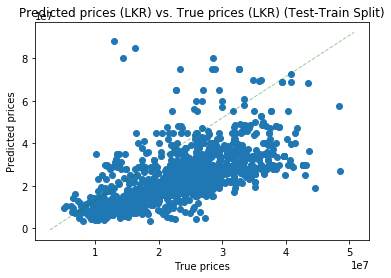

*********************************************************************
r2 :  -0.3457199541121605
best:  {'fit_intercept': True, 'normalize': True}
rmse:  9150323.1827253
*********************************************************************
Model does not support model coefficients
Model does not support feature importances


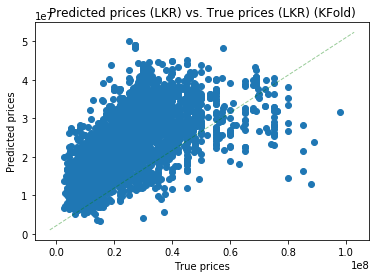

*********************************************************************
r2 :  0.439
best:  {'fit_intercept': True, 'normalize': True}
rmse:  8952470.227628471
*********************************************************************


In [42]:
model(linear_model.LinearRegression(), params_lr, X_train, Y_train, X, Y, X_test, Y_test)

      Location  Beds  Baths  House Size  Land Size
2981        28     4      4      4000.0      10.00
842         36     3      2       900.0       3.00
6465        35     3      2      1750.0       8.00
5939        35     3      2      1600.0       8.00
2690        13     5      4      3600.0       7.65
...        ...   ...    ...         ...        ...
4731        28     3      2      1350.0       6.00
6470        22     3      2      1400.0       7.50
6511        35     4      3      1658.0      13.00
6716        22     3      2      1650.0       8.00
1081        25     4      4      2500.0       7.00

[4566 rows x 5 columns]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=   0.0s
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=   0.0s
[CV] clf__n_neighbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............................. clf__n_neighbors=25, total=   0.0s
[CV] clf__n_neighbors=30 .............................................
[CV] .............................. clf__n_neighbors=30, total=   0.0s
[CV] clf__n_neighbors=30 .............................................
[CV] .............................. clf__n_neighbors=30, total=   0.0s
[CV] clf__n_neighbors=30 .............................................
[CV] .............................. clf__n_neighbors=30, total=   0.0s
#### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.005722      0.000566         0.009103        0.000607   
1       0.007866      0.003969         0.013740        0.003029   
2       0.004545      0.000277         0.008961        0.000102   
3       0.004242      0.000050         0.011825        0.001673   
4       0.005073      0.000888         0.013037        0.002321   

  param_clf__n_neighbors                    params  split0_test_score  \
0             

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished


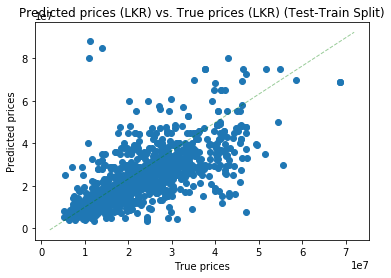

*********************************************************************
r2 :  0.22021734342232602
best:  {'clf__n_neighbors': 5}
rmse:  8260402.505177499
*********************************************************************
Model does not support model coefficients
Model does not support feature importances


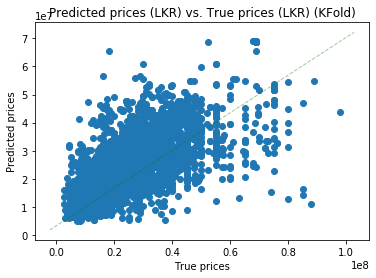

*********************************************************************
r2 :  0.539
best:  {'clf__n_neighbors': 5}
rmse:  8118906.094338808
*********************************************************************


In [43]:
 model(pipe_knn, param_knn, X_train, Y_train, X, Y, X_test, Y_test)

      Location  Beds  Baths  House Size  Land Size
2981        28     4      4      4000.0      10.00
842         36     3      2       900.0       3.00
6465        35     3      2      1750.0       8.00
5939        35     3      2      1600.0       8.00
2690        13     5      4      3600.0       7.65
...        ...   ...    ...         ...        ...
4731        28     3      2      1350.0       6.00
6470        22     3      2      1400.0       7.50
6511        35     4      3      1658.0      13.00
6716        22     3      2      1650.0       8.00
1081        25     4      4      2500.0       7.00

[4566 rows x 5 columns]
Fitting 3 folds for each of 280 candidates, totalling 840 fits
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=10 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=10 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=10, tota

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=20, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=50 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=50, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=50 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=50, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=50 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=50, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=70 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=70, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=70 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=70, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=70 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=70, 

[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  4.6min finished


#### Results
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
166       0.678495      0.020909         0.037191        0.000159   
207       0.763102      0.004890         0.043263        0.001546   
209       1.087792      0.003339         0.059339        0.000006   
204       0.554751      0.004318         0.030851        0.000130   
244       0.570292      0.005411         0.033392        0.003014   
..             ...           ...              ...             ...   
18        0.344392      0.191170         0.023774        0.014025   
13        0.102803      0.006660         0.007184        0.000182   
15        0.420781      0.100719         0.030768        0.013527   
19        0.386408      0.095611         0.025005        0.011874   
11        0.030252      0.001053         0.003206        0.000026   

    param_clf__max_depth param_clf__max_features param_clf__n_estimators  \
166                   15                    None                     130   
207   

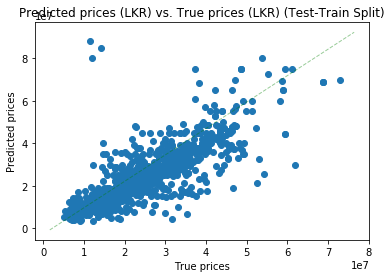

*********************************************************************
r2 :  0.5645201657778002
best:  {'clf__max_depth': 15, 'clf__max_features': None, 'clf__n_estimators': 130}
rmse:  6703882.922102241
*********************************************************************
Model does not support model coefficients
Feature importances:  [('Location', 0.2272611065535808), ('Beds', 0.04154428404290884), ('Baths', 0.05021864037608639), ('House Size', 0.5224368893534765), ('Land Size', 0.15853907967394745)]


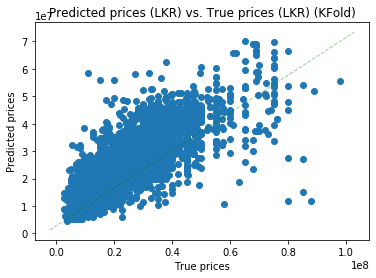

*********************************************************************
r2 :  0.716
best:  {'clf__max_depth': 15, 'clf__max_features': None, 'clf__n_estimators': 130}
rmse:  6357770.127571237
*********************************************************************


In [44]:
model(pipe_forest, param_forest, X_train, Y_train, X, Y, X_test, Y_test)


In [45]:
df_Y.describe()

count    6.088000e+03
mean     2.304999e+07
std      1.195597e+07
min      2.500000e+06
25%      1.500000e+07
50%      2.150000e+07
75%      2.900000e+07
max      9.800000e+07
Name: Price, dtype: float64